# Imports

In [1]:
import os
import base64
import joblib
import pandas as pd
import numpy as np
import category_encoders as ce
import json
import joblib
import pickle
import math
import requests
from copy import deepcopy
import seaborn as sns
from uuid import uuid4

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

from sklearn.base import BaseEstimator, TransformerMixin

from pandas_profiling import ProfileReport

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.style.use('ggplot')
%matplotlib inline

# Custom transformer imports

In [2]:
# WIP preprocessor which assigns categories and compresses some code
from custom_transformers.preprocessor import ColumnConverter

# WIP ordinal category preprocessor
from custom_transformers.custom_ordinal_encoder import custom_oe

#WIP column selector
from custom_transformers.featureselector import SelectColumns

# Functions

In [3]:
def load_train_data():
    df = pd.read_csv(os.path.join("data", "train_data.csv"))
    return df

data_train = load_train_data()

In [4]:
def assign_index(df, indexcol: str):
    _df = df.copy()
    _df = _df.set_index(indexcol)
    return _df

### These function will be replaced by the preprocessors
They have been left here in case I need to come back to them

In [5]:
def assign_categorical(df, column_list: []):
    _df = df.copy()
    for column in column_list:
        _df[column] = _df[column].astype('category')
    return _df

In [6]:
def encode_unordered_categorical(df, column_list: []):
    _df = df.copy()
    ohe = ce.OneHotEncoder(verbose=1,
                           cols=column_list,
                           handle_missing="indicator",
                           use_cat_names=True)
    _df = ohe.fit_transform(_df)
    return _df

In [7]:
def encode_ordinal_categorical(df, column_list: []):
    _df = df.copy()
    orde = ce.OrdinalEncoder(verbose=1,
                             cols=column_list,
                             handle_unknown='value',
                             handle_missing='value')
    _df = orde.fit_transform(_df)
    return _df

In [8]:
def build_target(df, target: str):
    _df = df.copy()
    _df[target] = np.where(_df[target]== 'Yes', True, False)
    return _df[target]

# Feature, index and targets
The features are listed as their intended category type (based on the provided data dictionary):

   1. numerical features
   2. boolean/binary features (mostly treated as categorical)
   3. unordered categories
   4. ordinal categories
   
Times and dates were requested but are unavailable

In [9]:
target = 'readmitted'

index_col = 'admission_id'

all_features = ['patient_id',
                'race',
                'gender',
                'age',
                'weight',                
                'admission_type_code', 
                'discharge_disposition_code',
                'admission_source_code', 
                'time_in_hospital', 
                'payer_code',
                'medical_specialty',
                'has_prosthesis',
                'complete_vaccination_status',
                'num_lab_procedures',
                'num_procedures',
                'num_medications',
                'number_outpatient',
                'number_emergency',
                'number_inpatient',
                'diag_1',
                'diag_2',
                'diag_3',
                'number_diagnoses',
                'blood_type',
                'hemoglobin_level',
                'blood_transfusion',
                'max_glu_serum',
                'A1Cresult',
                'diuretics',
                'insulin',
                'change',
                'diabetesMed']

num_features = ['time_in_hospital', 
                'num_lab_procedures',
                'num_procedures',
                'num_medications',
                'number_outpatient',
                'number_emergency',
                'number_inpatient',
                'number_diagnoses',
                'hemoglobin_level']

bool_features = ['has_prosthesis',
                 'blood_transfusion',
                 'diuretics',
                 'insulin',
                 'change',
                 'diabetesMed']

cat_features = ['race',
                'gender',
                'admission_type_code', 
                'discharge_disposition_code',
                'admission_source_code', 
                'payer_code',
                'medical_specialty',
                #'diag_1',
                #'diag_2',
                #'diag_3',
                #'blood_type',
                ]

ord_cat_features = ['age',
                    'weight', #lots of missing or unknown values
                    'max_glu_serum',
                    'A1Cresult',
                    'complete_vaccination_status',]
# missing features: date of admission and date of release

# Profile report
Generated using the data as originally provided, with no data cleaning or processing

In [10]:
# initial_profile = ProfileReport(data_train)
# initial_profile.to_file("initial_profile.html")

# Visualizations 1
Prepared before applying transformation to whole dataset

In [11]:
# Assigning categorical variables, but no encoding yet
testdf = assign_categorical(data_train, (cat_features + ord_cat_features + bool_features))

# Convert target to boolean
testdf['readmitted'] = build_target(testdf, 'readmitted')

In [12]:
# data = testdf.pivot_table(values=['readmitted'], index='gender', aggfunc=np.mean)*100
# plt.rcParams["figure.figsize"] = [3, 1]
# data.plot.barh(stacked=True, legend=None);
# plt.rcParams.update({'font.size': 12})
# plt.xlabel("% of patients readmitted", size=10)
# plt.ylabel("Gender", size=10)
# plt.title("Readmission and Gender", size=10);

In [13]:
# data = testdf.pivot_table(values=['readmitted'], index='race', aggfunc=np.mean)*100
# plt.rcParams["figure.figsize"] = [3, 15/3]
# data.plot.barh(stacked=True, legend=None).invert_yaxis();
# plt.rcParams.update({'font.size': 12})
# plt.xlabel("% of patients readmitted", size=10)
# plt.ylabel("Ethnicity", size=10)
# plt.title("Readmissions and Ethnicity", size=10);

In [14]:
# data = testdf.pivot_table(values=['readmitted'], index='age', aggfunc=np.mean)*100
# plt.rcParams["figure.figsize"] = [3, 10/3]
# data.plot.barh(stacked=True, legend=None);
# plt.rcParams.update({'font.size': 12})
# plt.xlabel("% of patients readmitted", size=10)
# plt.ylabel("Age", size=10)
# plt.title("Readmission and Age", size=10);

In [15]:
testdf.payer_code.nunique()

18

In [16]:
# data = testdf.pivot_table(values=['readmitted'], index='payer_code', aggfunc=np.mean)*100
# plt.rcParams["figure.figsize"] = [3, 18/3]
# data.plot.barh(stacked=True, legend=None);
# plt.rcParams.update({'font.size': 12})
# plt.xlabel("% of patients readmitted", size=10)
# plt.ylabel("Payer Code", size=10)
# plt.title("Readmission and Payer", size=10);

In [17]:
# specialty_summary = testdf.pivot_table(values=['readmitted'],
#                                        index='medical_specialty',
#                                        aggfunc=('count','mean'))
# specialty_summary = (specialty_summary[specialty_summary['readmitted']['count']>100].
#                      droplevel(0, axis=1)
#                     .rename(columns={'mean': '% readmitted'})
#                     .sort_values(by='% readmitted', ascending=False))

In [18]:
# data = specialty_summary.drop('count', axis=1).head(5)*100
# plt.rcParams["figure.figsize"] = [3, 5/3]
# data.plot.barh(stacked=True, legend=None).invert_yaxis();
# plt.rcParams.update({'font.size': 12})
# plt.xlabel("% of patients readmitted", size=10)
# plt.ylabel("Medical specialty", size=10)
# plt.title("Specialties with highest readmission rate", size=10);

In [19]:
# data = specialty_summary.drop('count', axis=1).tail(5)*100
# plt.rcParams["figure.figsize"] = [3, 5/3]
# data.plot.barh(stacked=True, legend=None).invert_yaxis();
# plt.rcParams.update({'font.size': 12})
# plt.xlabel("% of patients readmitted", size=10)
# plt.ylabel("Medical specialty", size=10)
# plt.title("Specialties with lowest readmission rate", size=10);

In [20]:
# data = (specialty_summary.drop('count', axis=1)
#         .drop('?', axis=0))*100
# plt.rcParams["figure.figsize"] = [3, 24/3]
# data.plot.barh(stacked=True, legend=None).invert_yaxis();
# plt.rcParams.update({'font.size': 12})
# plt.xlabel("% of patients readmitted", size=10)
# plt.ylabel("Medical specialty", size=10)
# plt.title("Specialties with at least 100 admissions", size=10);

In [21]:
# data = testdf.pivot_table(values=['readmitted'], index='weight', aggfunc=np.mean)*100
# plt.rcParams["figure.figsize"] = [3, 10/3]
# data.plot.barh(stacked=True, legend=None);
# plt.rcParams.update({'font.size': 12})
# plt.xlabel("% of patients readmitted", size=10)
# plt.ylabel("Weight", size=10)
# plt.title("Readmission and Weight", size=10);

In [22]:
# data = testdf.pivot_table(values=['readmitted'], index='blood_type', aggfunc=np.mean)*100
# plt.rcParams["figure.figsize"] = [3, 8/3]
# data.plot.barh(stacked=True, legend=None);
# plt.rcParams.update({'font.size': 12})
# plt.xlabel("% of patients readmitted", size=10)
# plt.ylabel("Blood type", size=10)
# plt.title("Blood Type and Weight", size=10);

In [23]:
# data = testdf.pivot_table(values=['readmitted'], index='max_glu_serum', aggfunc=np.mean)*100
# plt.rcParams["figure.figsize"] = [3, 6/3]
# data.plot.barh(stacked=True, legend=None);
# plt.rcParams.update({'font.size': 12})
# plt.xlabel("% of patients readmitted", size=10)
# plt.ylabel("Maximum Serum Glucose", size=10)
# plt.title("Readmission and Serum Glucose", size=10);

In [24]:
# data = testdf.pivot_table(values=['readmitted'], index='A1Cresult', aggfunc=np.mean)*100
# plt.rcParams["figure.figsize"] = [3, 4/3]
# data.plot.barh(stacked=True, legend=None);
# plt.rcParams.update({'font.size': 12})
# plt.xlabel("% of patients readmitted", size=10)
# plt.ylabel("A1C test result", size=10)
# plt.title("Readmission and A1C level", size=10);

In [25]:
# data = testdf.pivot_table(values=['readmitted'], index='admission_type_code', aggfunc=np.mean)*100
# plt.rcParams["figure.figsize"] = [3, 8/3]
# data.plot.barh(stacked=True, legend=None);
# plt.rcParams.update({'font.size': 12})
# plt.xlabel("% of patients readmitted", size=10)
# plt.ylabel("Admission type", size=10)
# plt.title("Readmission and Admission type", size=10);

In [26]:
# data = testdf.pivot_table(values=['readmitted'], index='admission_source_code', aggfunc=np.mean)*100
# plt.rcParams["figure.figsize"] = [3, 25/3]
# data.plot.barh(stacked=True, legend=None);
# plt.rcParams.update({'font.size': 12})
# plt.xlabel("% of patients readmitted", size=10)
# plt.ylabel("Admission source", size=10)
# plt.title("Readmission and Admission source", size=10);

In [27]:
# data = testdf.pivot_table(values=['readmitted'], index='discharge_disposition_code', aggfunc=np.mean)*100
# plt.rcParams["figure.figsize"] = [3, 28/3]
# data.plot.barh(stacked=True, legend=None);
# plt.rcParams.update({'font.size': 12})
# plt.xlabel("% of patients readmitted", size=10)
# plt.ylabel("Discharge Disposition", size=10)
# plt.title("Readmission and Discharge Disposition", size=10);

In [28]:
# fig, axes = plt.subplots(1,len(num_features), sharex=True) # create figure and axes
# plt.rcParams["figure.figsize"] = [15, 5]
# for i, ax in enumerate(axes.flat):
#     testdf.boxplot(column=num_features[i], by="readmitted", ax=axes.flatten()[i])
#     ax.set_title(str(num_features[i]), fontsize=10)
#     ax.xaxis.label.set_visible(False)
# fig.suptitle("Continuous features and readmission", size=12)
# plt.xlabel("% of patients readmitted", size=10)
# plt.tight_layout() 
# plt.show();

In [29]:
# fig, axes = plt.subplots(3,2, sharex=True) # create figure and axes
# plt.rcParams["figure.figsize"] = [6, 4]
# for i, ax in enumerate(axes.flat):
#     data = testdf.pivot_table(values=['readmitted'], index=bool_features[i], aggfunc=np.mean)*100
#     data.plot.barh(stacked=True, legend=None, ax=axes.flatten()[i]).invert_yaxis()
#     ax.set_title(str(bool_features[i]), fontsize=9)
#     ax.yaxis.label.set_visible(False)
# fig.suptitle("Binary features and readmission", size=10)
# plt.xlabel("% of patients readmitted", size=10)
# plt.show();

# Profile report after transforming data
Transformation done using the same functions applied for model development
No imputation or scaling 

In [30]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)],
remainder="passthrough",sparse_threshold=0)

In [31]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features)],
remainder="passthrough",sparse_threshold=0)

In [32]:
_df = data_train.copy()
_df['readmitted'] = build_target(_df, 'readmitted')
_df = _df.set_index('admission_id')

In [33]:
cc = ColumnConverter()
_df = cc.fit_transform(_df)

In [34]:
preprocessor.fit_transform(_df).shape

(81412, 33)

In [35]:
# ProfileReport(_df)

In [36]:
# profile_processed = ProfileReport(_df)
# profile_processed.to_file("processed_profile.html")

# Data technical summary

In [37]:
_df.patient_id.describe()

count    8.141200e+04
mean     1.086395e+08
std      7.732453e+07
min      1.980000e+02
25%      4.683906e+07
50%      9.083437e+07
75%      1.751117e+08
max      3.790052e+08
Name: patient_id, dtype: float64

In [38]:
for column in _df.columns.tolist():
    print(_df[column].describe())

count    8.141200e+04
mean     1.086395e+08
std      7.732453e+07
min      1.980000e+02
25%      4.683906e+07
50%      9.083437e+07
75%      1.751117e+08
max      3.790052e+08
Name: patient_id, dtype: float64
count     81412
unique        5
top       white
freq      60873
Name: race, dtype: object
count      81412
unique         3
top       female
freq       43719
Name: gender, dtype: object
count     81412
unique       11
top       70-80
freq      20261
Name: age, dtype: object
count       81412
unique         10
top       unknown
freq        78913
Name: weight, dtype: object
count         80250
unique            6
top       emergency
freq          42562
Name: admission_type_code, dtype: object
count               81412
unique                  7
top       discharged_home
freq                47854
Name: discharge_disposition_code, dtype: object
count         81412
unique            4
top       emergency
freq          45942
Name: admission_source_code, dtype: object
count    81412.00000

### correlations between numerical features

In [39]:
cor_mat = _df.corr()
lower_triangle_mask = np.triu(np.ones(cor_mat.shape)).astype(bool)
cor_mat_lower = cor_mat.mask(lower_triangle_mask)

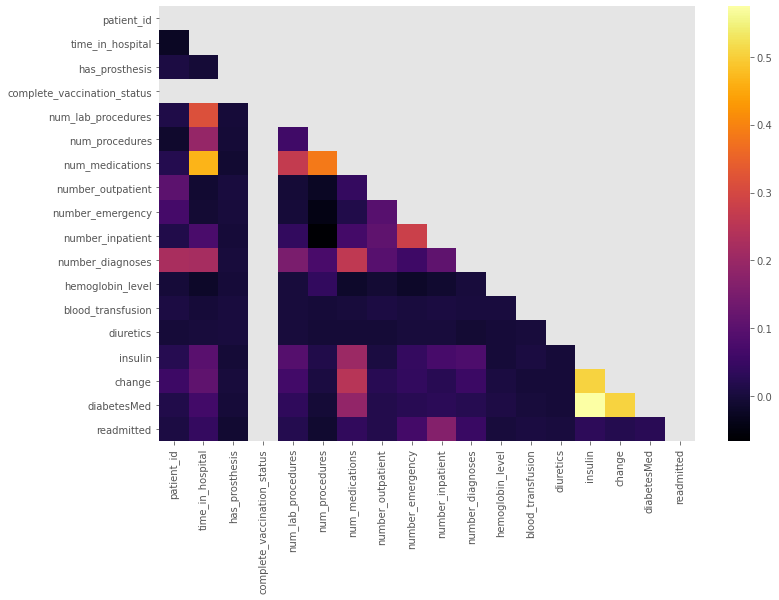

In [40]:
plt.figure(figsize = (12,8)) # <-- just sets the figure size 

sns.heatmap(cor_mat_lower, 
            annot=False,     # <-- write the numbers on the squares
            cmap='inferno'); # <-- use a "red into blue, reversed" colormap 

In [41]:
cor_mat_lower.unstack().dropna().nlargest(10)

insulin             diabetesMed           0.574090
change              diabetesMed           0.506269
insulin             change                0.505491
time_in_hospital    num_medications       0.464316
num_procedures      num_medications       0.386588
time_in_hospital    num_lab_procedures    0.315046
number_emergency    number_inpatient      0.281446
num_lab_procedures  num_medications       0.268071
num_medications     number_diagnoses      0.261044
                    change                0.247635
dtype: float64

In [42]:
cor_mat_lower.unstack().dropna().nsmallest(10)

num_procedures    number_inpatient    -0.065887
                  number_emergency    -0.041881
                  number_outpatient   -0.024351
patient_id        time_in_hospital    -0.023890
number_emergency  hemoglobin_level    -0.020732
time_in_hospital  hemoglobin_level    -0.018590
num_medications   hemoglobin_level    -0.018230
patient_id        num_procedures      -0.014419
number_inpatient  hemoglobin_level    -0.011542
num_procedures    readmitted          -0.011276
dtype: float64

In [43]:
cor_mat_lower.loc['readmitted'].sort_values(ascending = False)

number_inpatient               0.164781
number_emergency               0.065709
number_diagnoses               0.049817
time_in_hospital               0.042647
num_medications                0.039105
insulin                        0.033144
diabetesMed                    0.027206
change                         0.019311
num_lab_procedures             0.019160
number_outpatient              0.017730
patient_id                     0.008108
blood_transfusion              0.005350
diuretics                      0.001942
hemoglobin_level              -0.000169
has_prosthesis                -0.008412
num_procedures                -0.011276
complete_vaccination_status         NaN
readmitted                          NaN
Name: readmitted, dtype: float64

# Plots for data description

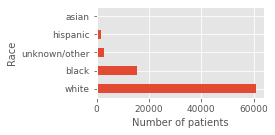

In [44]:
data = _df.race.value_counts()
plt.rcParams["figure.figsize"] = [3, 5/3]
data.plot.barh(stacked=True, legend=None);
plt.rcParams.update({'font.size': 12})
plt.xlabel("Number of patients", size=10)
plt.ylabel("Race", size=10)
plt.xticks(fontsize=9, rotation=0)
plt.yticks(fontsize=9, rotation=0);

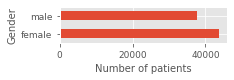

In [45]:
data = _df.gender.value_counts().nlargest(2) #this will exclude unknown values
plt.rcParams["figure.figsize"] = [3, 2/3]
data.plot.barh(stacked=True, legend=None);
plt.rcParams.update({'font.size': 12})
plt.xlabel("Number of patients", size=10)
plt.ylabel("Gender", size=10)
plt.xticks(fontsize=9, rotation=0)
plt.yticks(fontsize=9, rotation=0);

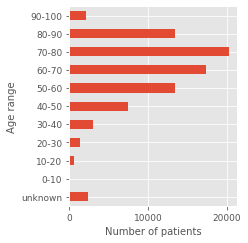

In [46]:
data = _df.age.value_counts().sort_index()
plt.rcParams["figure.figsize"] = [3, 11/3]
data.plot.barh(stacked=True, legend=None);
plt.rcParams.update({'font.size': 12})
plt.xlabel("Number of patients", size=10)
plt.ylabel("Age range", size=10)
plt.xticks(fontsize=9, rotation=0)
plt.yticks(fontsize=9, rotation=0);

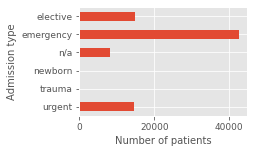

In [47]:
data = _df.admission_type_code.value_counts().sort_index(ascending=False)
plt.rcParams["figure.figsize"] = [3, 6/3]
data.plot.barh(stacked=True, legend=None);
plt.rcParams.update({'font.size': 12})
plt.xlabel("Number of patients", size=10)
plt.ylabel("Admission type", size=10)
plt.xticks(fontsize=9, rotation=0)
plt.yticks(fontsize=9, rotation=0);

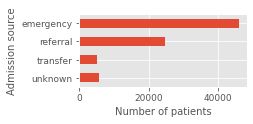

In [48]:
data = _df.admission_source_code.value_counts().sort_index(ascending=False)
plt.rcParams["figure.figsize"] = [3, 4/3]
data.plot.barh(stacked=True, legend=None);
plt.rcParams.update({'font.size': 12})
plt.xlabel("Number of patients", size=10)
plt.ylabel("Admission source", size=10)
plt.xticks(fontsize=9, rotation=0)
plt.yticks(fontsize=9, rotation=0);

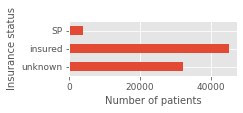

In [49]:
data = _df.payer_code.value_counts().sort_index(ascending=False)
plt.rcParams["figure.figsize"] = [3, 3/3]
data.plot.barh(stacked=True, legend=None);
plt.rcParams.update({'font.size': 12})
plt.xlabel("Number of patients", size=10)
plt.ylabel("Insurance status", size=10)
plt.xticks(fontsize=9, rotation=0)
plt.yticks(fontsize=9, rotation=0);

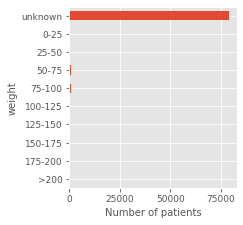

In [50]:
data = _df.weight.value_counts().sort_index(ascending=False)
plt.rcParams["figure.figsize"] = [3, 10/3]
data.plot.barh(stacked=True, legend=None);
plt.rcParams.update({'font.size': 12})
plt.xlabel("Number of patients", size=10)
plt.ylabel("weight", size=10)
plt.xticks(fontsize=9, rotation=0)
plt.yticks(fontsize=9, rotation=0);

In [51]:
_df[_df.medical_specialty != 'unknown'].medical_specialty.value_counts()

internalmedicine                     11712
emergency/trauma                      6021
family/generalpractice                5939
cardiology                            4273
surgery-general                       2473
nephrology                            1299
other                                 1187
orthopedics                           1100
orthopedics-reconstructive             981
radiologist                            913
pulmonology                            700
psychiatry                             674
urology                                539
obstetricsandgynecology                531
surgery-cardiovascular/thoracic        527
gastroenterology                       465
surgery-vascular                       438
surgery-neuro                          373
physicalmedicineandrehabilitation      298
oncology                               280
pediatrics                             211
neurology                              171
hematology/oncology                    165
pediatrics-

In [52]:
_df.medical_specialty.value_counts().nlargest(1).sort_values()

unknown    40020
Name: medical_specialty, dtype: int64

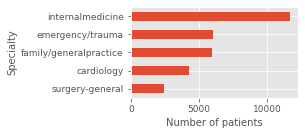

In [53]:
data = _df[_df.medical_specialty != 'unknown'].medical_specialty.value_counts().nlargest(5).sort_values()
plt.rcParams["figure.figsize"] = [3, 5/3]
data.plot.barh(stacked=True, legend=None);
plt.rcParams.update({'font.size': 12})
plt.xlabel("Number of patients", size=10)
plt.ylabel("Specialty", size=10)
plt.xticks(fontsize=9, rotation=0)
plt.yticks(fontsize=9, rotation=0);

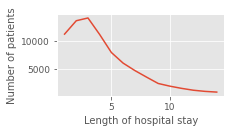

In [54]:
x = _df.time_in_hospital.value_counts().sort_index(ascending=True).index.tolist()
y = _df.time_in_hospital.value_counts().sort_index(ascending=True).values.tolist()
plt.rcParams["figure.figsize"] = [3, 1.5]
plt.plot(x, y);
plt.rcParams.update({'font.size': 12})
plt.xlabel("Length of hospital stay", size=10)
plt.ylabel("Number of patients", size=10)
plt.xticks(fontsize=9, rotation=0)
plt.yticks(fontsize=9, rotation=0);

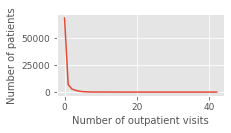

In [55]:
x = _df.number_outpatient.value_counts().sort_index(ascending=True).index.tolist()
y = _df.number_outpatient.value_counts().sort_index(ascending=True).values.tolist()
plt.rcParams["figure.figsize"] = [3, 1.5]
plt.plot(x, y);
plt.rcParams.update({'font.size': 12})
plt.xlabel("Number of outpatient visits", size=10)
plt.ylabel("Number of patients", size=10)
plt.xticks(fontsize=9, rotation=0)
plt.yticks(fontsize=9, rotation=0);

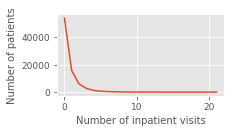

In [56]:
x = _df.number_inpatient.value_counts().sort_index(ascending=True).index.tolist()
y = _df.number_inpatient.value_counts().sort_index(ascending=True).values.tolist()
plt.rcParams["figure.figsize"] = [3, 1.5]
plt.plot(x, y);
plt.rcParams.update({'font.size': 12})
plt.xlabel("Number of inpatient visits", size=10)
plt.ylabel("Number of patients", size=10)
plt.xticks(fontsize=9, rotation=0)
plt.yticks(fontsize=9, rotation=0);

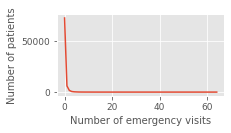

In [57]:
x = _df.number_emergency.value_counts().sort_index(ascending=True).index.tolist()
y = _df.number_emergency.value_counts().sort_index(ascending=True).values.tolist()
plt.rcParams["figure.figsize"] = [3, 1.5]
plt.plot(x, y);
plt.rcParams.update({'font.size': 12})
plt.xlabel("Number of emergency visits", size=10)
plt.ylabel("Number of patients", size=10)
plt.xticks(fontsize=9, rotation=0)
plt.yticks(fontsize=9, rotation=0);

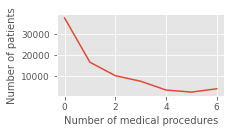

In [58]:
x = _df.num_procedures.value_counts().sort_index(ascending=True).index.tolist()
y = _df.num_procedures.value_counts().sort_index(ascending=True).values.tolist()
plt.rcParams["figure.figsize"] = [3, 1.5]
plt.plot(x, y);
plt.rcParams.update({'font.size': 12})
plt.xlabel("Number of medical procedures", size=10)
plt.ylabel("Number of patients", size=10)
plt.xticks(fontsize=9, rotation=0)
plt.yticks(fontsize=9, rotation=0);

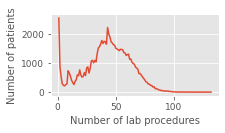

In [59]:
x = _df.num_lab_procedures.value_counts().sort_index(ascending=True).index.tolist()
y = _df.num_lab_procedures.value_counts().sort_index(ascending=True).values.tolist()
plt.rcParams["figure.figsize"] = [3, 1.5]
plt.plot(x, y);
plt.rcParams.update({'font.size': 12})
plt.xlabel("Number of lab procedures", size=10)
plt.ylabel("Number of patients", size=10)
plt.xticks(fontsize=9, rotation=0)
plt.yticks(fontsize=9, rotation=0);

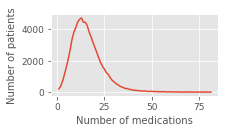

In [60]:
x = _df.num_medications.value_counts().sort_index(ascending=True).index.tolist()
y = _df.num_medications.value_counts().sort_index(ascending=True).values.tolist()
plt.rcParams["figure.figsize"] = [3, 1.5]
plt.plot(x, y);
plt.rcParams.update({'font.size': 12})
plt.xlabel("Number of medications", size=10)
plt.ylabel("Number of patients", size=10)
plt.xticks(fontsize=9, rotation=0)
plt.yticks(fontsize=9, rotation=0);

In [61]:
_df.diag_3.value_counts().nlargest(5).sort_values(ascending=False)

circulatory                               23979
endocrine_nutritional_metabolic_immune    20957
respiratory                                5447
genitourinary                              5065
ill_defined                                3611
Name: diag_3, dtype: int64

In [62]:
for feature in bool_features:
    print(_df[feature].value_counts())

False    80550
True       862
Name: has_prosthesis, dtype: int64
False    71697
True      9715
Name: blood_transfusion, dtype: int64
False    79893
True      1519
Name: diuretics, dtype: int64
True     44360
False    37052
Name: insulin, dtype: int64
False    43772
True     37640
Name: change, dtype: int64
True     62718
False    18694
Name: diabetesMed, dtype: int64


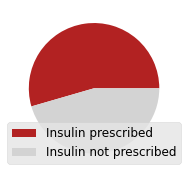

In [63]:
labels = ['Insulin prescribed', 'Insulin not prescribed']
values = testdf['insulin'].value_counts().values.tolist()[0:2]
colors = ['firebrick', 'lightgrey']
plt.rcParams["figure.figsize"] = [3, 3]
patches, texts = plt.pie(values, colors=colors, startangle=0)
plt.legend(patches, labels, loc="lower center");

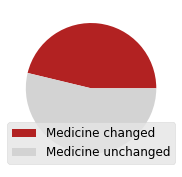

In [64]:
labels = ['Medicine changed', 'Medicine unchanged']
values = sorted(testdf['change'].value_counts().values.tolist())
colors = ['firebrick', 'lightgrey']
plt.rcParams["figure.figsize"] = [3, 3]
patches, texts = plt.pie(values, colors=colors, startangle=0)
plt.legend(patches, labels, loc="lower center");

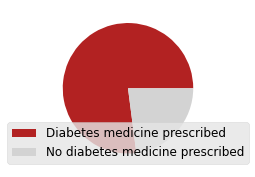

In [65]:
labels = ['Diabetes medicine prescribed', 'No diabetes medicine prescribed']
values = testdf['diabetesMed'].value_counts().values.tolist()[0:2]
colors = ['firebrick', 'lightgrey']
plt.rcParams["figure.figsize"] = [3, 3]
patches, texts = plt.pie(values, colors=colors, startangle=0)
plt.legend(patches, labels, loc="lower center");

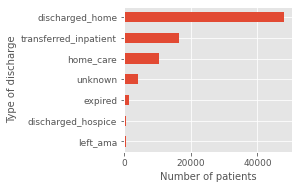

In [66]:
data = _df.discharge_disposition_code.value_counts().sort_values()
plt.rcParams["figure.figsize"] = [3, 8/3]
data.plot.barh(stacked=True, legend=None);
plt.rcParams.update({'font.size': 12})
plt.xlabel("Number of patients", size=10)
plt.ylabel("Type of discharge", size=10)
plt.xticks(fontsize=9, rotation=0)
plt.yticks(fontsize=9, rotation=0);

In [67]:
_df.readmitted.value_counts()

False    72340
True      9072
Name: readmitted, dtype: int64

In [68]:
#total_readmission 
pop_readmission = (_df.readmitted.value_counts()[1]/(_df.readmitted.value_counts()[0]+_df.readmitted.value_counts()[1]))*100

In [69]:
pop_readmission

11.14332039502776

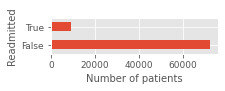

In [88]:
data = _df.readmitted.value_counts()
plt.rcParams["figure.figsize"] = [3, 2/3]
data.plot.barh(stacked=True, legend=None);
plt.rcParams.update({'font.size': 12})
plt.xlabel("Number of patients", size=10)
plt.ylabel("Readmitted", size=10)
plt.xticks(fontsize=9, rotation=0)
plt.yticks(fontsize=9, rotation=0);

# Answering the business questions

1. Investigate the provided data and determine if there is evidence of discrimination based on gender, ethnicity or age when dismissing patients from care.
2. Determine if the Medical Specialty the patient is under the care of, the admission source, or their insurance status is a potential source of this discrimination


#### Checking the overall rates
1. comparing gender
1. comparing race
1. comparing age
1. comparing ionsurance
1. comparing specialty
1. comparing admission source

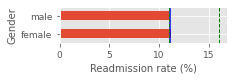

In [71]:
total_readmission = float(_df[_df.gender != 'unknown'].
                          pivot_table(values=['readmitted'],
                                      index='gender',
                                      aggfunc=np.sum)
                          .sum()
                          .values)
readmission_rate = (total_readmission)/(_df.gender.value_counts().sum())*100

data = _df[_df.gender != 'unknown'].pivot_table(values=['readmitted'], index='gender', aggfunc=np.mean)*100
plt.rcParams["figure.figsize"] = [3, 2/3]
data.plot.barh(stacked=True, legend=None);
plt.rcParams.update({'font.size': 12})
plt.xlabel("Readmission rate (%)", size=10)
plt.ylabel("Gender", size=10)
plt.xticks(fontsize=9, rotation=0)
plt.yticks(fontsize=9, rotation=0)
plt.axvline(x=readmission_rate, color='blue')
plt.axvline(x=data.values.min(), color='green', linestyle="--", linewidth=1)
plt.axvline(x=data.values.min()+5, color='green', linestyle="--", linewidth=1);

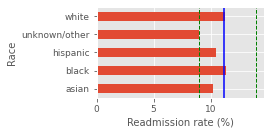

In [72]:
total_readmission = float(_df.pivot_table(values=['readmitted'],
                                      index='race',
                                      aggfunc=np.sum)
                          .sum()
                          .values)
readmission_rate = (total_readmission)/(_df.race.value_counts().sum())*100

data = _df.pivot_table(values=['readmitted'], index='race', aggfunc=np.mean)*100
plt.rcParams["figure.figsize"] = [3, 5/3]
data.plot.barh(stacked=True, legend=None);
plt.rcParams.update({'font.size': 12})
plt.xlabel("Readmission rate (%)", size=10)
plt.ylabel("Race", size=10)
plt.xticks(fontsize=9, rotation=0)
plt.yticks(fontsize=9, rotation=0)
plt.axvline(x=readmission_rate, color='blue')
plt.axvline(x=data.values.min(), color='green', linestyle="--", linewidth=1)
plt.axvline(x=data.values.min()+5, color='green', linestyle="--", linewidth=1);

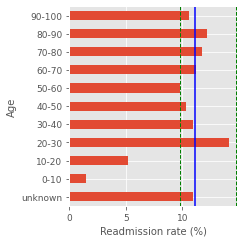

In [73]:
total_readmission = float(_df.pivot_table(values=['readmitted'],
                                      index='age',
                                      aggfunc=np.sum)
                          .sum()
                          .values)
readmission_rate = (total_readmission)/(_df.age.value_counts().sum())*100

data = _df.pivot_table(values=['readmitted'], index='age', aggfunc=np.mean)*100
plt.rcParams["figure.figsize"] = [3, 11/3]
data.plot.barh(stacked=True, legend=None);
plt.rcParams.update({'font.size': 12})
plt.xlabel("Readmission rate (%)", size=10)
plt.ylabel("Age", size=10)
plt.xticks(fontsize=9, rotation=0)
plt.yticks(fontsize=9, rotation=0)
plt.axvline(x=readmission_rate, color='blue')
plt.axvline(x=data.drop(['0-10', '10-20']).values.min(), color='green', linestyle="--", linewidth=1)
plt.axvline(x=data.drop(['0-10', '10-20']).values.min()+5, color='green', linestyle="--", linewidth=1);

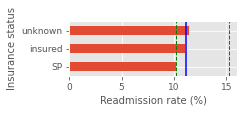

In [74]:
total_readmission = float(_df.pivot_table(values=['readmitted'],
                                      index='payer_code',
                                      aggfunc=np.sum)
                          .sum()
                          .values)
readmission_rate = (total_readmission)/(_df.payer_code.value_counts().sum())*100

data = _df.pivot_table(values=['readmitted'], index='payer_code', aggfunc=np.mean)*100
plt.rcParams["figure.figsize"] = [3, 3/3]
data.plot.barh(stacked=True, legend=None);
plt.rcParams.update({'font.size': 12})
plt.xlabel("Readmission rate (%)", size=10)
plt.ylabel("Insurance status", size=10)
plt.xticks(fontsize=9, rotation=0)
plt.yticks(fontsize=9, rotation=0)
plt.axvline(x=readmission_rate, color='blue')
plt.axvline(x=data.values.min(), color='green', linestyle="--", linewidth=1)
plt.axvline(x=data.values.min()+5, color='green', linestyle="--", linewidth=1);

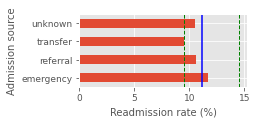

In [75]:
total_readmission = float(_df.pivot_table(values=['readmitted'],
                                      index='admission_source_code',
                                      aggfunc=np.sum)
                          .sum()
                          .values)
readmission_rate = (total_readmission)/(_df.admission_source_code.value_counts().sum())*100

data = _df.pivot_table(values=['readmitted'], index='admission_source_code', aggfunc=np.mean)*100
plt.rcParams["figure.figsize"] = [3, 4/3]
data.plot.barh(stacked=True, legend=None);
plt.rcParams.update({'font.size': 12})
plt.xlabel("Readmission rate (%)", size=10)
plt.ylabel("Admission source", size=10)
plt.xticks(fontsize=9, rotation=0)
plt.yticks(fontsize=9, rotation=0)
plt.axvline(x=readmission_rate, color='blue')
plt.axvline(x=data.values.min(), color='green', linestyle="--", linewidth=1)
plt.axvline(x=data.values.min()+5, color='green', linestyle="--", linewidth=1);

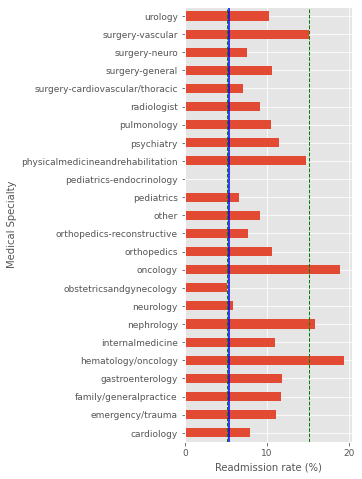

In [76]:
total_readmission = float(_df[_df.medical_specialty != 'unknown']
                          .pivot_table(values=['readmitted'],
                                       index='medical_specialty',
                                       aggfunc=np.sum)
                          .sum()
                          .values)
readmission_rate = (total_readmission)/(_df.medical_specialty.value_counts().sum())*100

data = _df[_df.medical_specialty != 'unknown']
data = data[data.medical_specialty != 'unknown'].pivot_table(values=['readmitted'], index='medical_specialty', aggfunc=np.mean)*100
plt.rcParams["figure.figsize"] = [3, 24/3]
data.plot.barh(stacked=True, legend=None);
plt.rcParams.update({'font.size': 12})
plt.xlabel("Readmission rate (%)", size=10)
plt.ylabel("Medical Specialty", size=10)
plt.xticks(fontsize=9, rotation=0)
plt.yticks(fontsize=9, rotation=0)
plt.axvline(x=readmission_rate, color='blue')
plt.axvline(x=data.drop(['pediatrics-endocrinology']).values.min(), color='green', linestyle="--", linewidth=1)
plt.axvline(x=data.drop(['pediatrics-endocrinology']).values.min()+10, color='green', linestyle="--", linewidth=1);

## Checking rates within admission source
#### comparing race

In [77]:
admission_types = _df.admission_source_code.unique().tolist()

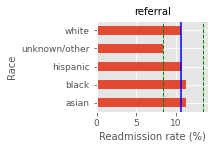

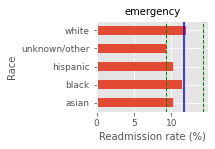

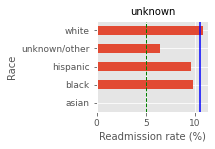

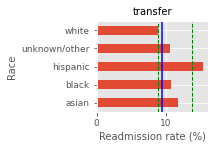

In [78]:
for admission in admission_types:
    data = _df[_df.admission_source_code == admission]
#     print(admission)
#     print(data.race.value_counts())
    total_readmission = float(data.pivot_table(values=['readmitted'], 
                                               index='race',aggfunc=np.sum)
                              .sum()
                              .values)
    readmission_rate = (total_readmission)/(data.race.value_counts().sum())*100
    
    data = data.pivot_table(values=['readmitted'], index='race', aggfunc=np.mean)*100
    plt.rcParams["figure.figsize"] = [2, 5/3]
    data.plot.barh(stacked=True, legend=None);
    plt.rcParams.update({'font.size': 12})
    plt.xlabel("Readmission rate (%)", size=10)
    plt.ylabel("Race", size=10)
    plt.xticks(fontsize=9, rotation=0)
    plt.yticks(fontsize=9, rotation=0)
    plt.title(admission, size=10)
    plt.axvline(x=readmission_rate, color='blue')
    plt.axvline(x=data.values.min(), color='green', linestyle="--", linewidth=1)
    plt.axvline(x=data.values.min()+5, color='green', linestyle="--", linewidth=1);
    plt.show

#### comparing gender

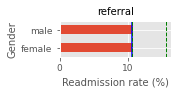

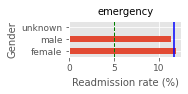

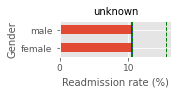

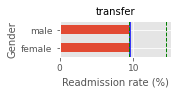

In [79]:
for admission in admission_types:
    data = _df[_df.admission_source_code == admission]
#     print(admission)
#     print(data.gender.value_counts())
    total_readmission = float(data.pivot_table(values=['readmitted'], 
                                               index='gender',aggfunc=np.sum)
                              .sum()
                              .values)
    readmission_rate = (total_readmission)/(data.gender.value_counts().sum())*100
    
    data = data.pivot_table(values=['readmitted'], index='gender', aggfunc=np.mean)*100
    plt.rcParams["figure.figsize"] = [2, 2/3]
    data.plot.barh(stacked=True, legend=None);
    plt.rcParams.update({'font.size': 12})
    plt.xlabel("Readmission rate (%)", size=10)
    plt.ylabel("Gender", size=10)
    plt.xticks(fontsize=9, rotation=0)
    plt.yticks(fontsize=9, rotation=0)
    plt.title(admission, size=10)
    plt.axvline(x=readmission_rate, color='blue')
    plt.axvline(x=data.values.min(), color='green', linestyle="--", linewidth=1)
    plt.axvline(x=data.values.min()+5, color='green', linestyle="--", linewidth=1);
    plt.show

referral
insured    13932
unknown     9597
SP          1181
Name: payer_code, dtype: int64
emergency
insured    26701
unknown    16519
SP          2722
Name: payer_code, dtype: int64
unknown
unknown    4163
insured    1477
SP           21
Name: payer_code, dtype: int64
transfer
insured    3021
unknown    1999
SP           79
Name: payer_code, dtype: int64


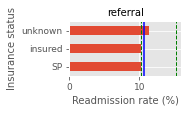

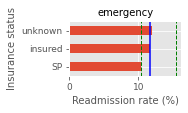

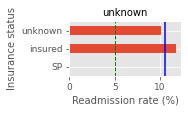

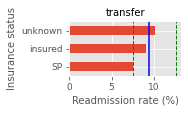

In [80]:
for admission in admission_types:
    data = _df[_df.admission_source_code == admission]
    print(admission)
    print(data.payer_code.value_counts())
    total_readmission = float(data.pivot_table(values=['readmitted'], 
                                               index='payer_code',aggfunc=np.sum)
                              .sum()
                              .values)
    readmission_rate = (total_readmission)/(data.payer_code.value_counts().sum())*100
    
    data = data.pivot_table(values=['readmitted'], index='payer_code', aggfunc=np.mean)*100
    plt.rcParams["figure.figsize"] = [2, 3/3]
    data.plot.barh(stacked=True, legend=None);
    plt.rcParams.update({'font.size': 12})
    plt.xlabel("Readmission rate (%)", size=10)
    plt.ylabel("Insurance status", size=10)
    plt.xticks(fontsize=9, rotation=0)
    plt.yticks(fontsize=9, rotation=0)
    plt.title(admission, size=10)
    plt.axvline(x=readmission_rate, color='blue')
    plt.axvline(x=data.values.min(), color='green', linestyle="--", linewidth=1)
    plt.axvline(x=data.values.min()+5, color='green', linestyle="--", linewidth=1);
    plt.show

referral
70-80      6248
60-70      6113
50-60      4425
80-90      3175
40-50      2189
30-40       911
unknown     710
20-30       394
90-100      368
10-20       143
0-10         34
Name: age, dtype: int64
emergency
70-80      11040
60-70       9204
80-90       8260
50-60       7371
40-50       4389
30-40       1723
90-100      1439
unknown     1310
20-30        759
10-20        357
0-10          90
Name: age, dtype: int64
unknown
70-80      1577
60-70      1087
80-90      1010
50-60       847
40-50       518
30-40       192
90-100      172
unknown     168
20-30        71
10-20        16
0-10          3
Name: age, dtype: int64
transfer
70-80      1396
60-70      1010
80-90       938
50-60       771
40-50       402
90-100      193
unknown     148
30-40       138
20-30        73
10-20        21
0-10          9
Name: age, dtype: int64


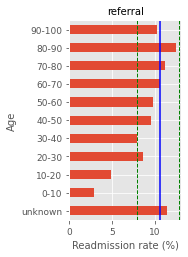

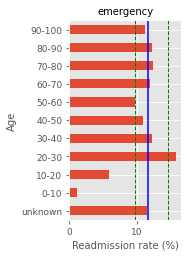

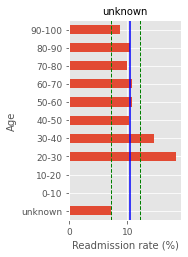

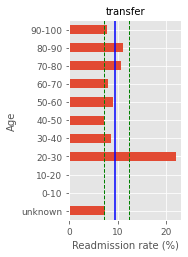

In [81]:
for admission in admission_types:
    data = _df[_df.admission_source_code == admission]
    print(admission)
    print(data.age.value_counts())
    total_readmission = float(data.pivot_table(values=['readmitted'], 
                                               index='age',aggfunc=np.sum)
                              .sum()
                              .values)
    readmission_rate = (total_readmission)/(data.age.value_counts().sum())*100
    
    data = data.pivot_table(values=['readmitted'], index='age', aggfunc=np.mean)*100
    plt.rcParams["figure.figsize"] = [2, 11/3]
    data.plot.barh(stacked=True, legend=None);
    plt.rcParams.update({'font.size': 12})
    plt.xlabel("Readmission rate (%)", size=10)
    plt.ylabel("Age", size=10)
    plt.xticks(fontsize=9, rotation=0)
    plt.yticks(fontsize=9, rotation=0)
    plt.title(admission, size=10)
    plt.axvline(x=readmission_rate, color='blue')
    plt.axvline(x=data.drop(['0-10', '10-20']).values.min(), color='green', linestyle="--", linewidth=1)
    plt.axvline(x=data.drop(['0-10', '10-20']).values.min()+5, color='green', linestyle="--", linewidth=1);
    plt.show

## Checking rates within medical specialty
#### comparing race

In [82]:
medical_specialties = _df.medical_specialty.unique().tolist()

/home/yash/.virtualenvs/bootcamp/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:337: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


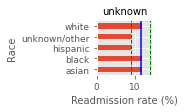

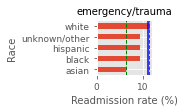

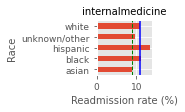

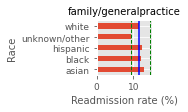

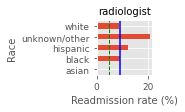

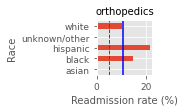

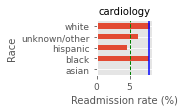

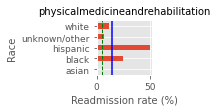

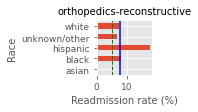

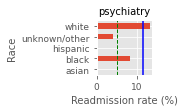

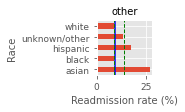

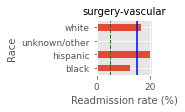

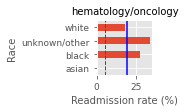

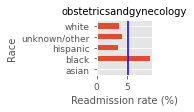

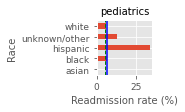

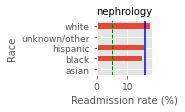

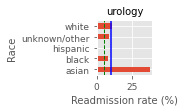

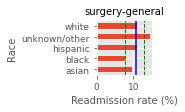

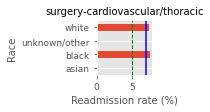

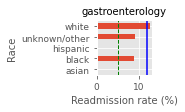

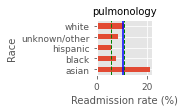

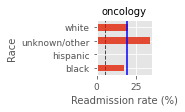

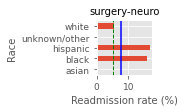

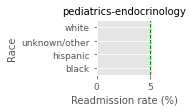

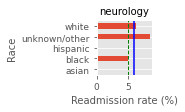

In [83]:
for specialty in medical_specialties:
    data = _df[_df.medical_specialty == specialty]
    
    total_readmission = float(data.pivot_table(values=['readmitted'], 
                                               index='race',aggfunc=np.sum)
                              .sum()
                              .values)
    readmission_rate = (total_readmission)/(data.race.value_counts().sum())*100
    
    data = data.pivot_table(values=['readmitted'], index='race', aggfunc=np.mean)*100
    plt.rcParams["figure.figsize"] = [1, 1]
    data.plot.barh(stacked=True, legend=None);
    plt.rcParams.update({'font.size': 12})
    plt.xlabel("Readmission rate (%)", size=10)
    plt.ylabel("Race", size=10)
    plt.xticks(fontsize=9, rotation=0)
    plt.yticks(fontsize=9, rotation=0)
    plt.title(specialty, size=10)
    plt.axvline(x=readmission_rate, color='blue')
    plt.axvline(x=data.values.min(), color='green', linestyle="--", linewidth=1)
    plt.axvline(x=data.values.min()+5, color='green', linestyle="--", linewidth=1);
    plt.show
    

unknown
female     21377
male       18641
unknown        2
Name: gender, dtype: int64
emergency/trauma
female     3219
male       2802
unknown       0
Name: gender, dtype: int64
internalmedicine
female     6647
male       5065
unknown       0
Name: gender, dtype: int64
family/generalpractice
female     3342
male       2597
unknown       0
Name: gender, dtype: int64
radiologist
male       514
female     399
unknown      0
Name: gender, dtype: int64
orthopedics
female     635
male       465
unknown      0
Name: gender, dtype: int64
cardiology
male       2373
female     1900
unknown       0
Name: gender, dtype: int64
physicalmedicineandrehabilitation
female     171
male       127
unknown      0
Name: gender, dtype: int64
orthopedics-reconstructive
female     593
male       388
unknown      0
Name: gender, dtype: int64
psychiatry
female     412
male       262
unknown      0
Name: gender, dtype: int64
other
female     654
male       533
unknown      0
Name: gender, dtype: int64
surgery-vasc

/home/yash/.virtualenvs/bootcamp/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:337: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


pediatrics-endocrinology
female     68
male       54
unknown     0
Name: gender, dtype: int64
neurology
male       97
female     74
unknown     0
Name: gender, dtype: int64


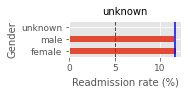

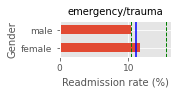

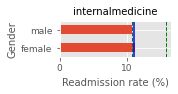

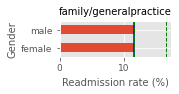

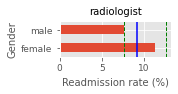

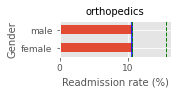

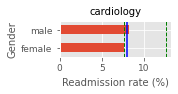

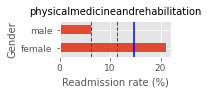

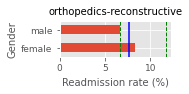

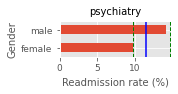

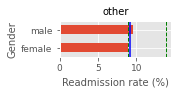

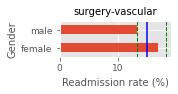

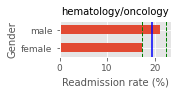

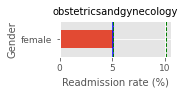

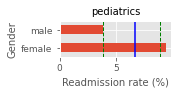

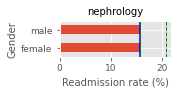

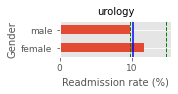

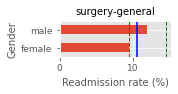

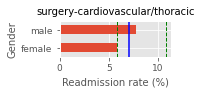

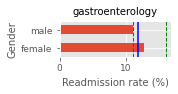

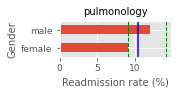

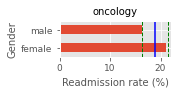

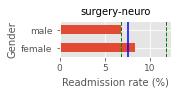

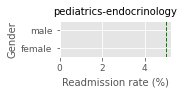

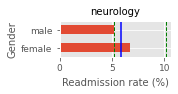

In [84]:
for specialty in medical_specialties:
    data = _df[_df.medical_specialty == specialty]
    print(specialty)
    print(data.gender.value_counts())
    total_readmission = float(data.pivot_table(values=['readmitted'], 
                                               index='gender',aggfunc=np.sum)
                              .sum()
                              .values)
    readmission_rate = (total_readmission)/(data.gender.value_counts().sum())*100
    
    data = data.pivot_table(values=['readmitted'], index='gender', aggfunc=np.mean)*100
    plt.rcParams["figure.figsize"] = [2, 2/3]
    data.plot.barh(stacked=True, legend=None);
    plt.rcParams.update({'font.size': 12})
    plt.xlabel("Readmission rate (%)", size=10)
    plt.ylabel("Gender", size=10)
    plt.xticks(fontsize=9, rotation=0)
    plt.yticks(fontsize=9, rotation=0)
    plt.title(specialty, size=10)
    plt.axvline(x=readmission_rate, color='blue')
    plt.axvline(x=data.values.min(), color='green', linestyle="--", linewidth=1)
    plt.axvline(x=data.values.min()+5, color='green', linestyle="--", linewidth=1);
    plt.show

/home/yash/.virtualenvs/bootcamp/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:337: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


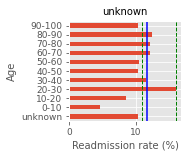

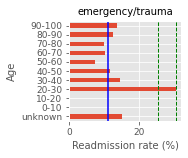

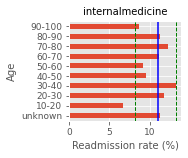

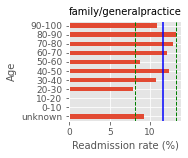

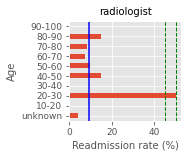

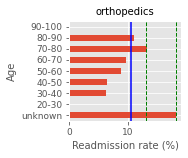

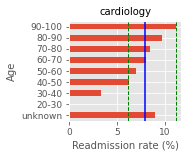

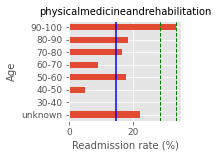

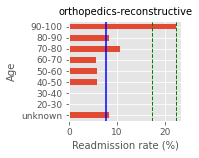

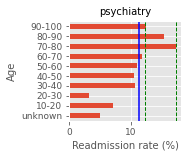

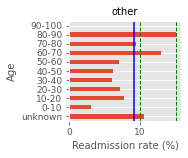

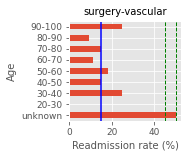

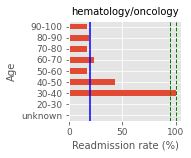

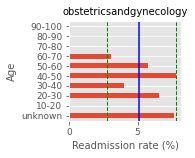

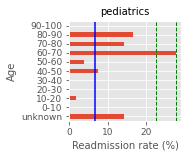

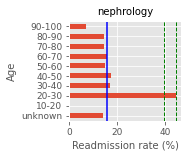

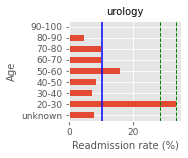

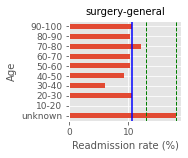

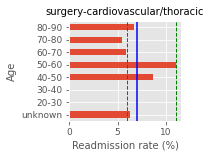

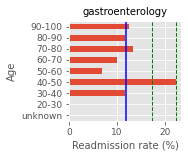

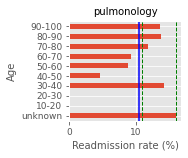

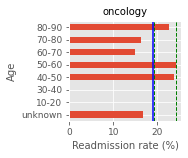

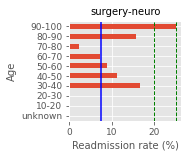

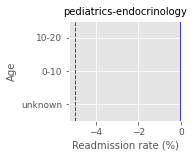

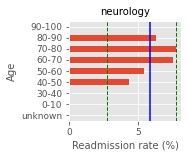

In [85]:
for specialty in medical_specialties:
    data = _df[_df.medical_specialty == specialty]
    
    total_readmission = float(data.pivot_table(values=['readmitted'], 
                                               index='age',aggfunc=np.sum)
                              .sum()
                              .values)
    readmission_rate = (total_readmission)/(data.age.value_counts().sum())*100
    
    data = data.pivot_table(values=['readmitted'], index='age', aggfunc=np.mean)*100
    plt.rcParams["figure.figsize"] = [2, 11/6]
    data.plot.barh(stacked=True, legend=None);
    plt.rcParams.update({'font.size': 12})
    plt.xlabel("Readmission rate (%)", size=10)
    plt.ylabel("Age", size=10)
    plt.xticks(fontsize=9, rotation=0)
    plt.yticks(fontsize=9, rotation=0)
    plt.title(specialty, size=10)
    plt.axvline(x=readmission_rate, color='blue')
    plt.axvline(x=data.values.max(), color='green', linestyle="--", linewidth=1)
    plt.axvline(x=data.values.max()-5, color='green', linestyle="--", linewidth=1);
    plt.show

/home/yash/.virtualenvs/bootcamp/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:337: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


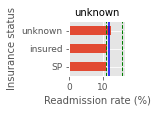

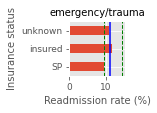

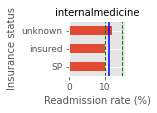

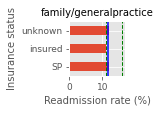

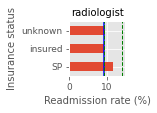

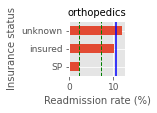

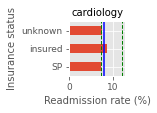

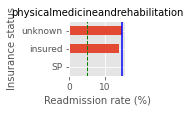

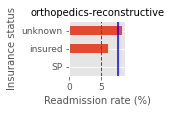

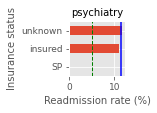

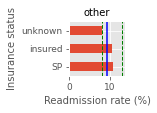

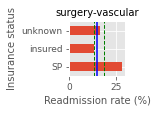

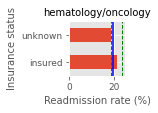

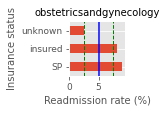

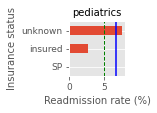

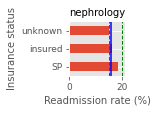

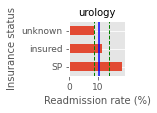

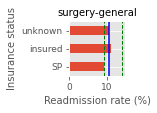

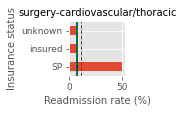

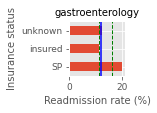

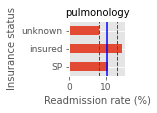

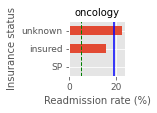

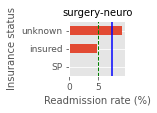

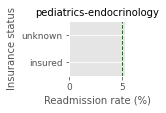

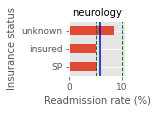

In [86]:
for specialty in medical_specialties:
    data = _df[_df.medical_specialty == specialty]
    
    total_readmission = float(data.pivot_table(values=['readmitted'], 
                                               index='payer_code',aggfunc=np.sum)
                              .sum()
                              .values)
    readmission_rate = (total_readmission)/(data.payer_code.value_counts().sum())*100
    
    data = data.pivot_table(values=['readmitted'], index='payer_code', aggfunc=np.mean)*100
    plt.rcParams["figure.figsize"] = [1, 1]
    data.plot.barh(stacked=True, legend=None);
    plt.rcParams.update({'font.size': 12})
    plt.xlabel("Readmission rate (%)", size=10)
    plt.ylabel("Insurance status", size=10)
    plt.xticks(fontsize=9, rotation=0)
    plt.yticks(fontsize=9, rotation=0)
    plt.title(specialty, size=10)
    plt.axvline(x=readmission_rate, color='blue')
    plt.axvline(x=data.values.min(), color='green', linestyle="--", linewidth=1)
    plt.axvline(x=data.values.min()+5, color='green', linestyle="--", linewidth=1);
    plt.show